# I am going to make the automated workflow for Gaussian Plume model to the 2D transmittance image using the code below 

In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from gaussian_plume_functions import *
from scipy.special import erfcinv

# Directory to save 3D plume concentrations field
output_dir = "../output_data/gplume_conc/"

# Constants and configurations
dxy = 20  # resolution of the model in both x and y directions (meters)
dz = 10   # resolution of the model in the z direction (meters)
num_xygrid = 100
num_zgrid = 50
days = 1  # run the model for 1 day

# Define a 3D grid using dxy and dz with the center at the source location
grid_x, grid_y, grid_z = np.meshgrid(
    np.arange(-dxy * num_xygrid/2, dxy * num_xygrid/2, dxy),  # X-axis grid
    np.arange(-dxy * num_xygrid/2, dxy * num_xygrid/2, dxy),  # Y-axis grid
    np.arange(0, dz * num_zgrid, dz),                        # Z-axis grid
    indexing='ij'
)

print("Grid dimensions:", grid_x.shape, grid_y.shape, grid_z.shape)

# Parameters for wind direction generation
mean_wind_directions = [20, 80]  # Mean wind direction 
direction_spreads = [20, 60]  # Spread around the mean direction

# Parameters to determine atmospheric stability
day_or_night = [True, False]
incoming_solar_radiations = ["strong", "moderate", "weak"]
cloud_covers = ["high", "low"]

# Stack configurations 
stack_x = [0.]  # X-coordinates of stacks
stack_y = [0.]  # Y-coordinates of stacks
initial_Q = 1   # Initial emission rate in kg/s
H = [10.]       # Stack height in meters

# Iterate over each stack location
for s in range(len(H)):
    for wind_speed in [3.5, 6.5]: 
        # Rough time estimate for the plume to reach steady state
        rough_steady_state_time = num_xygrid * dxy / np.sqrt(wind_speed)
        print(f"Steady state in ~{rough_steady_state_time} seconds")

        for WD_mean in mean_wind_directions:
            for spread in direction_spreads:
                # Generate random wind directions
                wind_dir = WD_mean + spread * np.sqrt(2.) * erfcinv(2. * np.random.rand(24 * days, 1))
                wind_dir = np.mod(wind_dir, 360)  # Ensure within 0-360 degrees

                # Initialize concentration array
                big_C = np.zeros((grid_x.shape[0], grid_y.shape[1], grid_z.shape[2], len(wind_dir)))

                for day_time in day_or_night:
                    for incoming_solar_radiation in incoming_solar_radiations: 
                        for cloud_cover in cloud_covers:
                            # Compute stability class
                            stab_class = get_stab_class(wind_speed, day_time, 
                                                        solar_radiation=incoming_solar_radiation, 
                                                        cloud_cover_fraction=cloud_cover)

                            print(f"Stability class for wind speed {wind_speed} is {stab_class}")

                            # Iterate over each wind direction
                            for i in range(len(wind_dir)):
                                wind_direction = wind_dir[i, 0]
                                WA = np.radians(wind_direction)
                                WA_x, WA_y = np.cos(WA), np.sin(WA)
                                
                                # Compute concentrations using the Gaussian Plume model
                                concentrations = gplume(initial_Q, stab_class, stack_x[s], stack_y[s], 
                                                        H[s], grid_x, grid_y, grid_z, wind_speed, WA_x, WA_y)
                                big_C[:, :, :, i] += concentrations  # ug/m3 

                                print(f"Plume at direction {wind_direction:.2f} degrees, concentration array shape:", big_C.shape)

                            # Average over wind directions
                            mean_conc = np.mean(big_C, axis=3)
                            
                            # Save mean_conc
                            file_name = f"gplume_output_WS_{wind_speed}_stability_{stab_class}_WD_{WD_mean}_spread_{spread}.npy"
                            np.save(os.path.join(output_dir, file_name), mean_conc)

                            # Plotting the 2D plume concentration
                            plot_2d_plume_concentration(mean_conc, f"WS_{wind_speed}_stability_{stab_class}_WD_{WD_mean}_spread_{spread}")

print("Simulation completed.")

   


## Compute transmittance with concentration fields

In [24]:
from hapi import *
import ssl
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap 
import h5py

# grid information needed to transmittance calculation
dz = 10   # resolution of the model in the z direction (meters)

# Set necessary for accessing HITRAN database 
os.environ['GLOBAL_HOST'] = 'http://hitran.org'
ssl._create_default_https_context = ssl._create_unverified_context

# file with satellite bands
satellites = ["sentinel2"]

output_dir = "../output_data/gplume_transmit/"

# Directory where 3D plume concentrations fields are saved
conc_dir = "../output_data/gplume_conc/"

for filename in os.listdir(conc_dir):
    # read concentration fields
    mean_conc = np.load(os.path.join(conc_dir,filename))
    print(f"reading concentrations from {filename}")

    print(mean_conc.shape)

    # linear increase with emission and convert concentration from ug m-3 to kg m-3
    for Q_target in [7000, 10000]: # kg/hr 
        mean_conc = mean_conc /1e9 * (Q_target/3600) # kg/m-3 

        print(mean_conc.mean(),abs_coef.mean() )


        
        for satellite in satellites: 
            obs_file = f"../input_data/{satellite}_band_wavelength.csv"

            bands = pd.read_csv(obs_file)
            print(bands)

            # subset the data based on CH4_AC > 0 
            subset_bands = bands[bands["CH4_AC"] < 0]
            subset_bands = subset_bands[["Wavelength_start", "Wavelength_end", "CH4_AC"]]

            print(subset_bands)

            for index, row in subset_bands.iterrows():
                wavelength_start = row["Wavelength_start"]
                wavelength_end = row["Wavelength_end"]
                ch4_ac = row["CH4_AC"]
            
                #Compute wavelength range and wavenumber in cm^-1
                low_wavenumbers = 1.e7 / wavelength_end
                high_wavenumbers = 1.e7 / wavelength_start

                print("target wavenumbers", low_wavenumbers, high_wavenumbers)

                # Set the local folder to download the HITRAN data
                db_begin('/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran')
                fetch('CH4',6,1,low_wavenumbers,high_wavenumbers)
                describeTable('CH4')

                # HITRAN_units : cm^2/molec (if True) and cm-1 (if False) and  WavenumberStep default value is 0.01 cm-1 but changed to 1 for now
                nu,abs_coef = absorptionCoefficient_Lorentz(SourceTables='CH4', Diluent={'air':1.0}, HITRAN_units=True, Environment ={'T':296.,'p':1.}, WavenumberStep = 0.1)

                # NOTE - see the below where the HITRAN absorption coefficient is compared to the satellite data

                # convert cm^2/mole to m2/kg, which is the concentration unit from the Gaussian Model. 
                ch4_molar_weight = 0.01604 # kg/mole 
                Avogadro = 6.022e23 # molecules per mole
                convert_unit = Avogadro/ch4_molar_weight/1e4 
                abs_coef= abs_coef*convert_unit # cm2/mole to m2/kg

                # Reshape the arrays to be 5D dimensions to compute extinction
                value_reshaped = mean_conc[:, :, :,  np.newaxis]  # (lon, lat, height, 1)
                wavenumber_dim = len(abs_coef)
                abs_coef_reshaped = abs_coef.reshape(1, 1, 1, wavenumber_dim)
                extinction_per_layer = value_reshaped * dz * abs_coef_reshaped # dz = 10 (grid height) 
                print("extinction per layer ", extinction_per_layer.shape, extinction_per_layer.mean())

                # Summing over height
                total_extinction = np.sum(extinction_per_layer, axis=2)  
                print("total_extinction ", total_extinction.shape)

                # Average over the last dimension, wavenumbers
                final_data = np.mean(total_extinction, axis=-1)  # Resulting shape will be (lon, lat)
                print("final_data ", final_data.shape, final_data.mean())

                # colors = ["white", "red"]  # white for low concentrations, red for high
                # cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=256)

                # plt.figure(figsize=(10, 6))
                # plt.imshow(final_data[:, :], cmap=cmap, origin='lower')
                # plt.colorbar(label='Averaged Total Extinction over wavelength')
                # plt.title(f'Averaged Total Extinction')
                # plt.xlabel('Longitude Index')
                # plt.ylabel('Latitude Index')
                # plt.show()


                colors = ["red", "white"]  # white for low concentrations, red for high
                cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=256)

                # Calculate total transmittance based on Beer-Lambert Law
                #enhance_signal = 1
                final_transmittance = np.exp(-final_data) # * enhance_signal
                print("total_transmittance ", final_transmittance.shape, final_transmittance.mean())


                # plt.figure(figsize=(10, 6))
                # img = plt.imshow(final_transmittance[:, :], cmap=cmap, origin='lower')
                # cbar = plt.colorbar(img, label='Total Transmittance')

                # # Manually set the colorbar ticks
                # cbar_ticks = np.linspace(final_transmittance.min(), 1, num=5)
                # cbar.set_ticks(cbar_ticks)

                # # Manually format the colorbar tick labels
                # cbar_labels = [f'{tick:.3f}' for tick in cbar_ticks]  # Format in scientific notation with 3 decimal places
                # cbar.set_ticklabels(cbar_labels)
                # plt.title(f'Total Transmittance')
                # plt.xlabel('Longitude Index')
                # plt.ylabel('Latitude Index')
                # plt.show()

                # Save output
                file_name = f"transmittance_Q_{Q_target}_satellite_{satellite}_wavestart_{wavelength_start}_waveend_{wavelength_end}_{filename}.h5"
                with h5py.File(os.path.join(output_dir, file_name), 'w') as hf:
                    hf.create_dataset('CH4 transmittance', data=final_transmittance)


reading concentrations from gplume_output_WS_6.5_stability_D_WD_20_spread_60.npy
(100, 100, 50)
1.932457647808272e-07 0.3985398445752038
    Unnamed: 0 Band Wavelength Range (nm)  Resolution (m)  \
0            0    1             433 – 453              60   
1            1    2             458 – 523              10   
2            2    3             543 – 578              10   
3            3    4             650 – 680              10   
4            4    5             698 – 713              20   
5            5    6             733 – 748              20   
6            6    7             773 – 793              20   
7            7    8             785 – 900              10   
8            8   8a             855 – 875              20   
9            9    9             930 – 950              60   
10          10   10           1360 – 1390              60   
11          11   11           1565 – 1655              20   
12          12   12           2100 – 2280              20   

        

# read carbonmapper plume image to get the concentration range



Warning 3: Cannot find header.dxf (GDAL_DATA is not defined)


DataArray info:
<xarray.DataArray (band: 4, y: 151, x: 151)> Size: 91kB
[91204 values with dtype=uint8]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
    xc           (y, x) float64 182kB 3.607e+05 3.607e+05 ... 3.612e+05
    yc           (y, x) float64 182kB 3.799e+06 3.799e+06 ... 3.799e+06
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
('band', 'y', 'x')
Coordinates:
  * band         (band) int64 32B 1 2 3 4
    xc           (y, x) float64 182kB 3.607e+05 3.607e+05 ... 3.612e+05
    yc           (y, x) float64 182kB 3.799e+06 3.799e+06 ... 3.799e+06
    spatial_ref  int64 8B 0
{'AREA_OR_POINT': 'Area', 'scale_factor': 1.0, 'add_offset': 0.0}
CRS: EPSG:32611
Bounds: (360660.9674670138, 3798675.389420468, 361053.5674670138, 3799067.989420468)


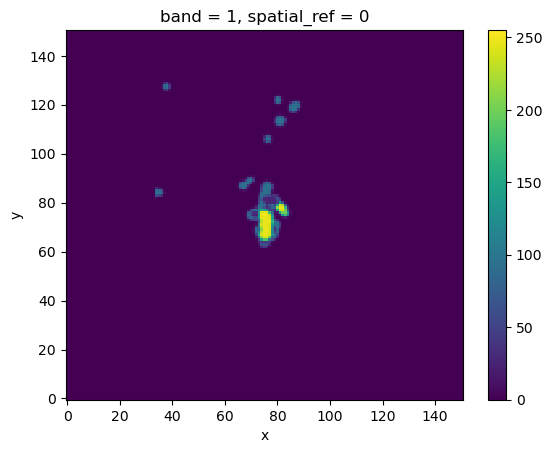

In [25]:
import xarray as xr
import rioxarray

# Path to the GeoTIFF file
file = "/Users/yunhalee/Documents/methanDart/carbonmapper/CarbonMapper_Aerial/carbonmapper_ch4_rgb_geotiffs_2020_2021/carbonmapper_ch4_rgb_geotiffs_2020_2021/ang20200708t192518-3_r1823_c108_ctr.tif"

# Open the GeoTIFF file as an xarray DataArray
data = rioxarray.open_rasterio(file)

# Display basic information about the data
print("DataArray info:")
print(data)

# Plotting the first band (or all bands if it's a multi-band image)
data.plot()

print(data.dims) 
print(data.coords)  
print(data.attrs) 

band1 = data.sel(band=1) 
band1.plot()  # Plot the first band

print("CRS:", data.rio.crs) 
print("Bounds:", data.rio.bounds()) 

## TODO - find out the unit of the data

# Compare the CH4 absorption coefficient used in Satellite Bands against the HITRAN database

    Unnamed: 0 Band Wavelength Range (nm)  Resolution (m)  \
0            0    1             433 – 453              60   
1            1    2             458 – 523              10   
2            2    3             543 – 578              10   
3            3    4             650 – 680              10   
4            4    5             698 – 713              20   
5            5    6             733 – 748              20   
6            6    7             773 – 793              20   
7            7    8             785 – 900              10   
8            8   8a             855 – 875              20   
9            9    9             930 – 950              60   
10          10   10           1360 – 1390              60   
11          11   11           1565 – 1655              20   
12          12   12           2100 – 2280              20   

                    Description  Wavelength_start  Wavelength_end    CH4_AC  
0               Coastal Aerosol               433             453  

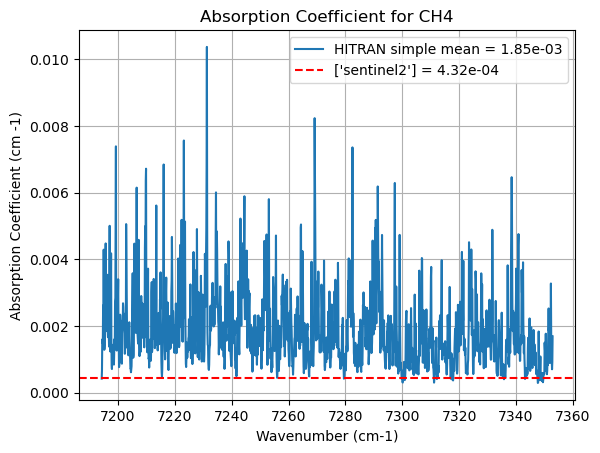

target wavenumbers 6042.296072507553 6389.776357827476
Using /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran

CH4
                     Lines parsed: 4954
H2O
                     Lines parsed: 11257

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CH4
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Pu

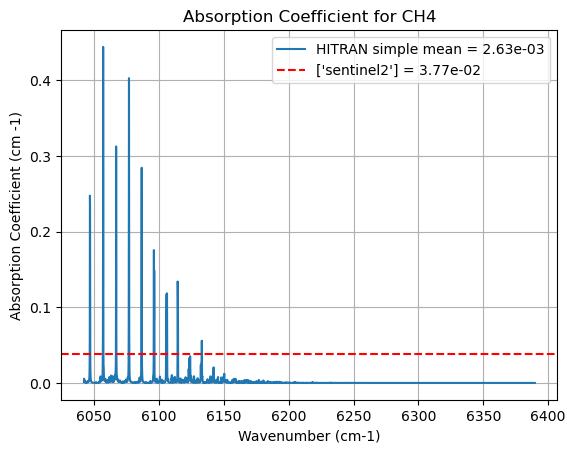

target wavenumbers 4385.964912280701 4761.9047619047615
Using /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran

CH4
                     Lines parsed: 5831
H2O
                     Lines parsed: 11257

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CH4
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_P

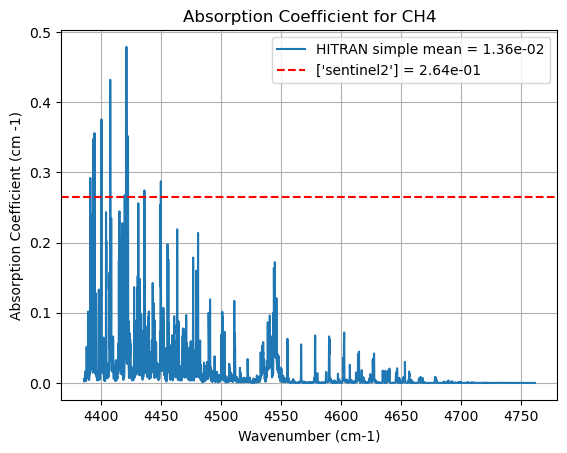

In [17]:
from hapi import *
import ssl
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set necessary for accessing HITRAN database 
os.environ['GLOBAL_HOST'] = 'http://hitran.org'
ssl._create_default_https_context = ssl._create_unverified_context

# file with satellite bands
satellites = ["sentinel2"]

for satellite in satellites: 
    obs_file = f"../input_data/{satellite}_band_wavelength.csv"

    bands = pd.read_csv(obs_file)
    print(bands)

    # subset the data based on CH4_AC > 0 
    subset_bands = bands[bands["CH4_AC"] < 0]
    subset_bands = subset_bands[["Wavelength_start", "Wavelength_end", "CH4_AC"]]

    print(subset_bands)

    for index, row in subset_bands.iterrows():
        wavelength_start = row["Wavelength_start"]
        wavelength_end = row["Wavelength_end"]
        ch4_ac = row["CH4_AC"]
    
        #Compute wavelength range and wavenumber in cm^-1
        low_wavenumbers = 1.e7 / wavelength_end
        high_wavenumbers = 1.e7 / wavelength_start

        print("target wavenumbers", low_wavenumbers, high_wavenumbers)

        # Set the local folder to download the HITRAN data
        db_begin('/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran')
        fetch('CH4',6,1,low_wavenumbers,high_wavenumbers)
        describeTable('CH4')

        # HITRAN_units : cm^2/molec (if True) and cm-1 (if False) and  WavenumberStep default value is 0.01 cm-1 but changed to 1 for now
        nu,abs_coef = absorptionCoefficient_Lorentz(SourceTables='CH4', Diluent={'air':1.0}, HITRAN_units=False, Environment ={'T':296.,'p':1.}, WavenumberStep = 0.1)

        # Filter out zero values
        filtered_abs_coef = abs_coef[abs_coef > 0]

        # Compute effective absorption coefficient (This is smaller than simple averaging)
        if len(filtered_abs_coef) > 0:
            effective_abs_coef = np.exp(np.mean(np.log(filtered_abs_coef)))
        else:
            effective_abs_coef = 0  # or handle this case as needed

        print(len(abs_coef), abs_coef.mean(), effective_abs_coef, np.abs(ch4_ac))

        # Plot the absorption coefficient
        plt.plot(nu, abs_coef, label=f'HITRAN simple mean = {abs_coef.mean():.2e}')
        plt.axhline(y=np.abs(ch4_ac), color='r', linestyle='--', label=f'{satellites} = {np.abs(ch4_ac):.2e}')
        #plt.text(0.05, 0.95, f'Mean Absorption Coefficient: {abs_coef.mean():.2e}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        #plt.text(0.05, 0.90, f'|ch4_ac|: {np.abs(ch4_ac):.2e}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        plt.xlabel('Wavenumber (cm-1)')
        plt.ylabel('Absorption Coefficient (cm -1)')
        plt.title('Absorption Coefficient for CH4')
        plt.legend()
        plt.grid(True)
        plt.show()

        # convert cm^2/mole to m2/kg, which is the concentration unit from the Gaussian Model. 
        ch4_molar_weight = 0.01604 # kg/mole 
        Avogadro = 6.022e23 # molecules per mole
        convert_unit = Avogadro/ch4_molar_weight/1e4 # cm2/mole to m2/kg
        abs_coef= abs_coef*convert_unit